In [151]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import warnings
from functools import partial
import copy
import pandas as pd
from scipy.linalg import solve

In [152]:
plt.style.use('seaborn')
from pylab import rcParams
plt.rcParams['figure.dpi'] = 90
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [203]:
def finDif(omega,f,n,bc):
    h=(omega[1]-omega[0])/(n-1) 
    
    x = np.zeros(n)
    b = np.zeros(n)
    for i in range (0,n):   
      x[i]=i*h    
      b[i]=f(x[i])   
    
    b[0], b[-1]=bc   
    
    A = np.diag([-1 for i in range(0,n-2)], -2)  \
    + np.diag([16 for i in range(0,n-1)], -1)    \
    + np.diag([-30 for i in range(0,n)])         \
    + np.diag([16 for i in range(0,n-1)], 1)     \
    + np.diag([-1 for i in range(0,n-2)], 2)      
    
    A=-A/(12*h**2)   

    return A, b

Call the function using:

In [204]:
omega = [0,np.pi]
f = lambda x : np.sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [205]:
def LU(A):
    n = A.shape[0]
    L = np.zeros_like(A)
    U = np.zeros_like(A)
    for k in range(n):
        U[k, k] = A[k, k]
        for i in range(k+1,n):
            L[i, k] = np.divide(A[i, k], U[k, k])
            U[k, i] = A[k, i]
        for i in range(k+1,n):
            for j in range(k+1,n):
                A[i,j] = A[i,j] - L[i,k]*U[k,j]
    np.fill_diagonal(L,1)
    return L,U

L, U = LU(A)

In [206]:
def cholesky(A):
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        A[k,k] = np.sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - (A[j:N,k]*A[j,k])
            
    A[-1,-1] = np.sqrt(A[-1,-1])
    L=np.tril(A)
    return L, L.transpose()

HT, H = cholesky(A)

/tmp/ipykernel_2286/1014600759.py:5: RuntimeWarning: invalid value encountered in sqrt
  A[k,k] = np.sqrt(A[k,k])


Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [208]:
def L_solve(L,rhs):
    x = np.zeros_like(rhs)
    N = len(L)
        
    x[0] = rhs[0]/L[0,0]
    for i in range(1,N):
        x[i] = (rhs[i] - np.dot(L[i, 0:i], x[0:i]))/L[i,i] 
    return x

In [209]:
def U_solve(U,rhs):
    x = np.zeros_like(rhs)
    N = len(U)
        
    x[-1] = rhs[-1]/U[-1,-1]
    
    for i in reversed(range(N-1)):
        x[i] = (rhs[i] - np.dot(U[i, (i+1):N], x[(i+1):N]))/U[i,i]
    
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

In [210]:
def solve_system(A, b):
    L, U = LU(A)
    
    y=L_solve(L, b)  
    x=U_solve(U, y)
    
    return x

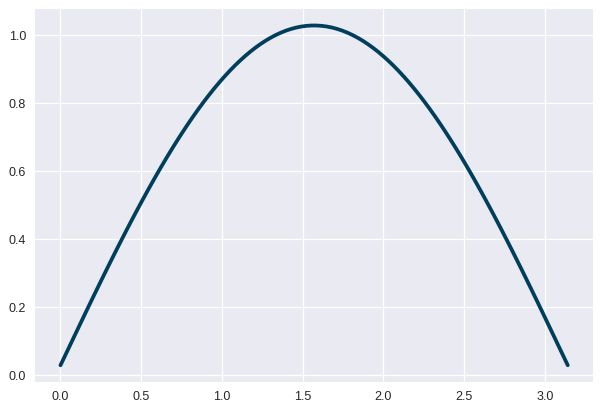

In [211]:
y = L_solve(L,b)
u = U_solve(U,y)
x = np.linspace(0,np.pi, n)

plt.plot(x,u, color='#003f5c', linewidth=3)

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

In [212]:
omega2 = [0,1]
f2 = lambda x : x*(1-x)
fsol_analytical = lambda x: np.power(x,4) / 12 - np.power(x,3) / 6 + x / 12
bc2 = [0,0]
n_range = np.arange(10,500, 10)
err_approx= np.zeros(len(n_range))

/tmp/ipykernel_2286/3133342579.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  _ = plt.semilogy(n_range, err_approx, 'r-', color='#003f5c', linewidth=3)


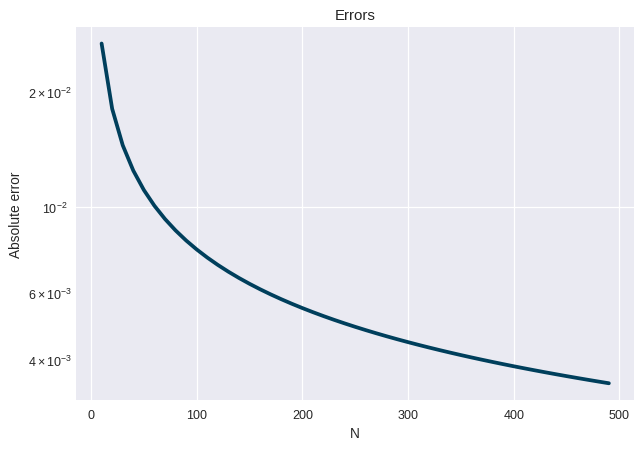

In [213]:
for i,n_val in enumerate(n_range):
  x=np.linspace(0,1,n_val)
  A_new, b_new = finDif(omega2, f2, n_val, bc)
  HT_new, H_new = cholesky(A_new)
  y_new = L_solve(HT_new,b_new)
  u_app = U_solve(H_new,y_new)
  u_an = fsol_analytical(x)
  err_approx[i] = np.linalg.norm(abs(u_an - u_app), 2)

Table_errors = pd.DataFrame({'N' : n_range, 'error' : err_approx})  
Table_errors.head()

plt.title("Errors")
plt.xlabel('N')
plt.ylabel('Absolute error')
_ = plt.semilogy(n_range, err_approx, 'r-', color='#003f5c', linewidth=3)

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [214]:
omega = [0,np.pi]
f = lambda x : np.sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

In [215]:
def power_method(A,z0,tol,n_max):
    q = z0/(np.linalg.norm(z0,2))
    it = 0
    err = tol + 1.
    
    while it < n_max and err > tol:
        z = np.dot(A,q)
        l = np.dot(q.T,z)
        err = np.linalg.norm(z-l*q,2)
        q = z/np.linalg.norm(z,2)
        it += 1
    
    return l,q

In [216]:
def inverse_power_method(A,x0,mu,tol,n_max):
    I = np.eye(len(A))
    M = A - mu*I
    L,U = LU(M)
    q = x0/np.linalg.norm(x0,2)
    err = tol + 1.0
    it = 0
    
    while it < n_max and err > tol:
        y = L_solve(L,q)
        x = U_solve(U,y)
        q = x/np.linalg.norm(x,2)
        z = np.dot(A,q)
        l = np.dot(q.T,z)
        err = np.linalg.norm(z-l*q,2)
        it += 1
    return l,q 

In [217]:
def cond_numb(A):
    z0 = np.random.rand(A.shape[0])
    mu = 0.0
    tol = 1.e-6

    n_max = 10000
    l_max = power_method(A,z0,tol,n_max)[0]
    l_min = inverse_power_method(A,z0,mu,tol,n_max)[0]

    cond_nu = l_max/l_min
    
    return cond_nu

print(cond_numb(A))

5493.885940073508


Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [218]:
def conjugate_gradient(A, b, P=None, eps=1e-10):
    if P is None:
        P = np.identity(A.shape[0])
    
    x = np.zeros_like(A[0])
    r = b - A.dot(x)
    z = np.linalg.solve(P, r)
    p = z
    
    for i in range(len(A)):
        if np.linalg.norm(r) < eps:
            break
            
        a = p.dot(r) / A.dot(p).dot(p)
        x += a*p
        r -= a*A.dot(p)
        z = np.linalg.solve(P, r)
        beta = A.dot(p).dot(z) / A.dot(p).dot(p)
        p = z - beta*p
        
    return x

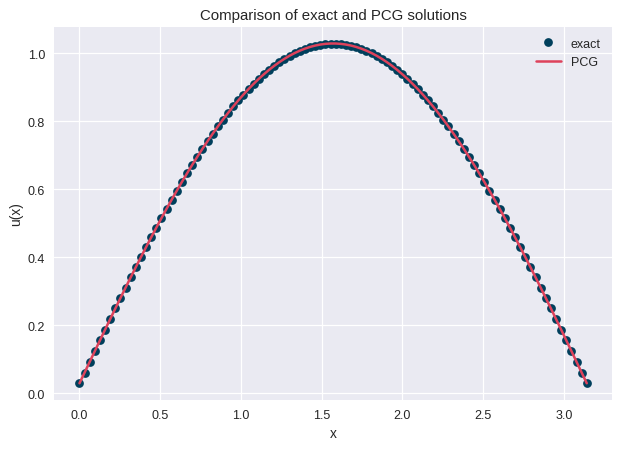

In [219]:
n=100
x=np.linspace(omega[0],omega[1],100)
sol_conjugate_gradient = conjugate_gradient(A,b,np.identity(len(A)))

# Old solution
w = L_solve(L,b)
u = U_solve(U,w)

# Scipy solution
u_ex = scipy.linalg.solve(A, b)

plt.title('Comparison of exact and PCG solutions')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.plot(x,u_ex,'o', color='#003f5c', label='exact')
plt.plot(x,sol_conjugate_gradient,'-', color='#de425b', label='PCG', linewidth=2)
plt.legend(loc='best')
plt.show()

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


## Forward Euler method

First, we discretize the time using the Forward Euler approximation for the first derivative with respect to  t:
$$
\dfrac{\partial{u}}{\partial{t}}(x,t) \sim \dfrac{u(x,t_{n+1}) - u(x, {t_n}))}{h_t} 
$$

This allows us to rewrite the time-dependent solution of the PDE as:
$$
u(x,t_{n+1}) = u(x,t_n) + h_{t}u_{xx}(x,t_n) + h_{t}\alpha{t_n}f(x)
$$

Then, we adopt the finite difference scheme used in the first point for the spatial derivative:
$$
u_{xx}(x,t) \sim u_{xx}(x_i,t) = \dfrac{-u(x_{i-2},t) + 16u(x_{i-1},t)-30u(x_i,t)+16u(x_{i+1},t) - u(x_{i+2},t)}{12h_{x}^2}
$$
We obtain the following numerical scheme:
$$
u(x_m, t_{n+1}) = u(x_m,t_n) + h_t\dfrac{-u(x_{m-2},t_n) + 16u(x_{m-1},t_n)-30u(x_m,t_n)+16u(x_{m+1},t_n) - u(x_{m+2},t_n)}{12h_{x}^2} + h_t\alpha{(t_n)}f(x_m)
$$
that can be rewritten in a more useful form as:
$$
u(x_m, t_{n+1}) = h_t\left(\dfrac{-u(x_{m-2}, t_n) + 16u(x_{m-1},t_n)-(30-12h_{x}^2 / h_t)u(x_m,t_n)+16u(x_{m+1},t_n)-u(x_{m+2},t_n)}{12h_{x}^2} + \alpha{(t_n)}f(x_m) \right)
$$
We can now write the problem in the following form for some matrix $A \in \mathbb{R}^{N_x \times N_x}$
$$
\left(\begin{array}{cc} 
u(x_0) \\
\vdots \\
u(x_{Nx})
\end{array}\right) (t_{n+1}) = A
\left(\begin{array}{cc} 
u(x_0) \\
\vdots \\
u(x_{Nx})
\end{array}\right) (t_n) +
\left(\begin{array}{cc} 
f(x_0) \\
\vdots \\
f(x_{Nx})
\end{array}\right) h_t\alpha{(t_n)}
$$ 
Where $N_x$ is an integer such that $N_xh_x$ is equal to the right boundary of the space domain

In [220]:
def forward_euler_A(ht, hx, Nx):
    A = np.zeros((Nx,Nx), dtype=float)
    
    non_null_component = np.array([-1, 16, -30+12*hx**2/ht, 16, -1])

    for i in range(2,Nx-2):
        A[i,i-2:i+3] = np.array(non_null_component) / 12

    A[1,0:3] = A[-2,-3:] = np.array([1,-2+hx**2/ht,1])
    
    A /= hx**2
    A *= ht
    
    return A

def forward_euler(u0, f, alpha, omega_x, omega_t, Nx, Nt):
    if not isinstance(u0, np.ndarray):
        u0 = np.repeat(u0, Nx)
    
    ht = (omega_t[1] - omega_t[0]) / Nt
    hx = (omega_x[1] - omega_x[0]) / Nx
    
    xs = np.linspace(*omega_x, Nx)
    ts = np.linspace(*omega_t, Nt)
    
    A = forward_euler_A(ht, hx, Nx)
    f = np.vectorize(f)(xs)
    
    u = np.zeros((Nx, Nt), dtype=float)
    u[:,0] = u0
    
    u[[0,-1],0] = 0
    f[[0,-1]] = 0
    
    for i in range(1,Nt):
        u[:,i] = A.dot(u[:,i-1]) + ht * alpha(i*ht) * f
        
    return xs,ts,u

In [170]:
alpha_function = lambda x: np.cos(x)
f = lambda x: np.sin(x)

x_50, t_50, u_50 = forward_euler(0, f, alpha_function, (0,np.pi), (0,6*np.pi), Nx=50, Nt=100000)
x_1000, t_1000, u_1000 = forward_euler(0, f, alpha_function, (0,np.pi), (0,6*np.pi), Nx=1000, Nt=100000)

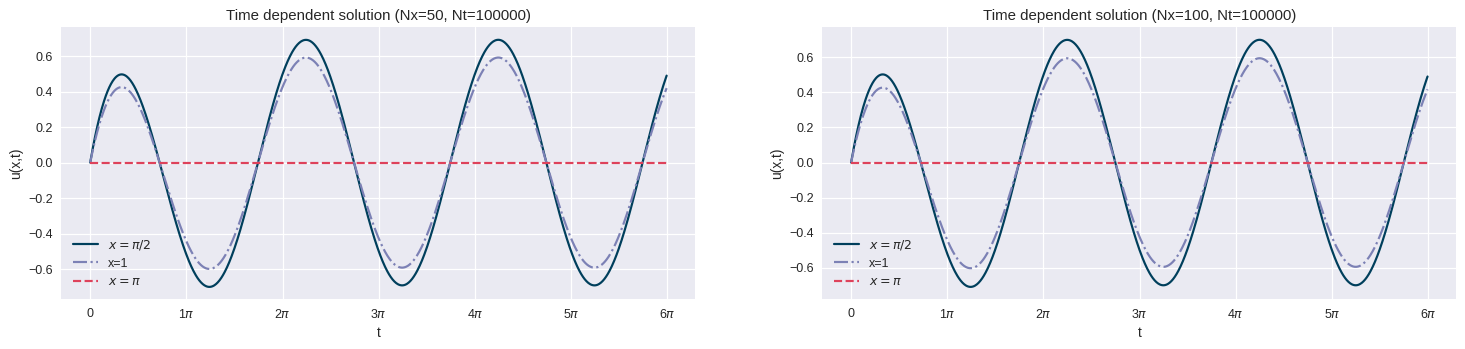

In [171]:
def show_solution(Nx, Nt, *, xs=None):
    xs, ts, u = forward_euler(0, np.sin, np.cos, (0,np.pi), (0,6*np.pi), Nx=Nx, Nt=Nt)

    pi_2_idx = np.argmin(abs(xs - np.pi/2))
    one_idx = np.argmin(abs(xs - 1))
    pi_idx = -1

    time = slice(None,None,100)

    plt.plot(ts[time], u[pi_2_idx,time], '-', color='#003f5c', label=r'$x=\pi/2$' )
    plt.plot(ts[time], u[one_idx,time], '-.', color='#7c81b5', label='x=1')
    plt.plot(ts[time], u[pi_idx,time], '--', color='#de425b', label=r'$x=\pi$')

    plt.xticks([i*np.pi for i in range(7)], ['0', *('{}$\\pi$'.format(i) for i in range(1,7))])

    plt.xlabel('t')
    plt.ylabel('u(x,t)')

    plt.title('Time dependent solution (Nx={}, Nt={})'.format(Nx,Nt))
    plt.legend()

plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
show_solution(50,100000)
plt.subplot(1,2,2)
show_solution(100,100000)
plt.show()

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [174]:
def eigenvalues_LU(A,tol,iteration=2000):
    B = A.copy()
    eigval_old = np.diag(B)
    err = tol+1.0
    it = 0
    
    for i in range(iteration):
        if err > tol:
            L,U = LU(B)
            B = np.matmul(U,L)
            eigval_new = np.diag(B)  
            err = np.linalg.norm(eigval_new - eigval_old,2)
            it += 1
            eigval_old = eigval_new
        
    return eigval_new

def eigenvectors_LU(A,tol,nmax):
    eigvecs = np.zeros_like(A)
    n = A.shape[0]
    q = np.random.rand(n)
    eigvals = eigenvalues_LU(A,tol,2000)
    new_eigvals = np.zeros(len(eigvals))
    for i in range(len(eigvals)):
        eigval_val, eigvec_val = inverse_power_method(A,q,eigvals[i]+tol,tol,nmax)    
        new_eigvals[i] = eigval_val
        eigvecs[i,:] = eigvec_val
         
    return new_eigvals, eigvecs

In [175]:
n_max = 10000
tol = 1e-10
eigenvalues=eigenvalues_LU(A,tol,2000)
shifted_eigenvalues, eigenvectors = eigenvectors_LU(A,tol,n_max)


eigenvalues_numpy,eigenvectors_numpy = np.linalg.eig(A)


print("lambda_max:", max(shifted_eigenvalues))

lambda_max: 5294.663145551342


Compute the inverse of the matrix A exploiting the derived LU factorization

In [ ]:
#estimation of the inverse of matrix A, using the LU decomposition
I = np.identity(n)
Y= solve(L,I,lower=True)
A_inv_LU = solve(U,Y)

#estimation of the inverse using Numpy
A_inv_numpy = np.linalg.inv(A)

print("Max difference between elements in the numpy inverse and our estimated inverse matrix : ")
print(max(abs(A_inv_LU - A_inv_numpy).flatten()))


#print(A_inverse)

Max difference between elements in the numpy inverse and our estimated inverse matrix : 
1.4606371667724716e-15


Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

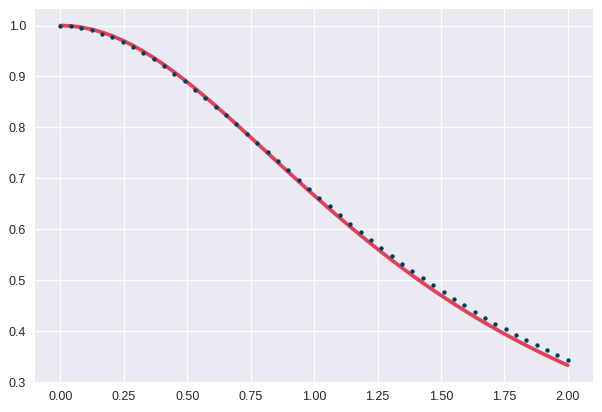

In [ ]:
def newton(y, y_prev, n, h, phi, phi_prime, iterations=0, n_max=100, tolerance=1.e-12):
    t = n*h
    y -= phi(y,y_prev,t) / phi_prime(t)
    
    if phi(y,y_prev,t) < tolerance or iterations >= n_max:
        return y
    else:
        return newton(y, y_prev, n, h, phi, phi_prime, iterations+1, n_max, tolerance)

def backward_euler(omega,n,bc):
    h = (omega[1] - omega[0]) / n
    
    def phi(x, y, t):
        return t*h*x**2 + x - y

    def phi_prime(t):
        return 2*t*h + 1
    
    y = np.zeros(n, dtype=float)
    y[0] = bc
    for i in range(1,n):
        y[i] = newton(y[i-1], y[i-1], i, h, phi, phi_prime)
    return y

def exact(x):
    return 1/(x**2/2+1)

n = 50
omega3 = (0,2)
plt.plot(np.linspace(*omega3,n), exact(np.linspace(*omega3,n)), color='#de425b', linewidth=3);
plt.plot(np.linspace(*omega3,n), backward_euler(omega3, n, 1), '.', color='#003f5c', linewidth=3)